## Kaggle/Dacon 필사
#### 1) Model: XGBoost
#### 2) Dataset: HR Analytics: Job Change of Data Scientists (Kaggle)
#### 3) 목적: Predict who will move to a new job
#### 4) 필사 Code: https://www.kaggle.com/code/nkitgupta/who-will-leave-a-job#Various-Approaches-to-Handle-Missing-values-in-Categorical-Features-
------------

### 1. Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier

In [2]:
df_train = pd.read_csv('aug_train.csv')
df_test = pd.read_csv('aug_test.csv')

In [3]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


##### target: 0 – Not looking for job change, 1 Looking for a job change

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


In [7]:
df_test['target'] = -1 # 합치기 위한 컬럼 추가. 나중에 drop할 컬럼
df_pre = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

In [8]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  object 
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  object 
 4   relevent_experience     21287 non-null  object 
 5   enrolled_university     20870 non-null  object 
 6   education_level         20775 non-null  object 
 7   major_discipline        18162 non-null  object 
 8   experience              21217 non-null  object 
 9   company_size            14727 non-null  object 
 10  company_type            14513 non-null  object 
 11  last_new_job            20824 non-null  object 
 12  training_hours          21287 non-null  int64  
 13  target                  21287 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

#### ▶ Encoding

##### 결측값을 NONE과 같은 값으로 채운 후 인코딩해서 수치형으로 변환

In [9]:
from sklearn.preprocessing import LabelEncoder

df_lb = df_pre.copy()
df_lb['education_level'].value_counts()

education_level
Graduate          12867
Masters            4857
High School        2239
Phd                 468
Primary School      344
Name: count, dtype: int64

In [10]:
df_lb.loc[:, "education_level"] = df_lb['education_level'].fillna("NONE")

In [11]:
lbl_enc = LabelEncoder()
df_lb.loc[:, "education_level"] = lbl_enc.fit_transform(df_lb['education_level'].values)
df_lb['education_level'].value_counts()

education_level
0    12867
2     4857
1     2239
3      512
4      468
5      344
Name: count, dtype: int64

In [12]:
gender_map = {
    'Female': 2,
    'Male': 1,
    'Other': 0}

relevent_experience_map = {
    'Has relevent experience': 1,
    'No relevent experience': 0}

enrolled_university_map = {
    'no_enrollment': 0,
    'Full time course': 1,
    'Part time course': 2}

education_level_map = {
    'Primary School': 0,
    'Graduate': 2,
    'Masters': 3,
    'High School': 1,
    'Phd': 4}

major_map = {
    'STEM': 0,
    'Business Degree': 1,
    'Arts': 2,
    'Humanities': 3,
    'No Major': 4,
    'Other': 5}

experience_map = {
    '<1'      :    0,
    '1'       :    1, 
    '2'       :    2, 
    '3'       :    3, 
    '4'       :    4, 
    '5'       :    5,
    '6'       :    6,
    '7'       :    7,
    '8'       :    8, 
    '9'       :    9, 
    '10'      :    10, 
    '11'      :    11,
    '12'      :    12,
    '13'      :    13, 
    '14'      :    14, 
    '15'      :    15, 
    '16'      :    16,
    '17'      :    17,
    '18'      :    18,
    '19'      :    19, 
    '20'      :    20, 
    '>20'     :    21}

company_type_map = {
    'Pvt Ltd'               :    0,
    'Funded Startup'        :    1, 
    'Early Stage Startup'   :    2, 
    'Other'                 :    3, 
    'Public Sector'         :    4, 
    'NGO'                   :    5}

company_size_map = {
    '<10'          :    0,
    '10/49'        :    1, 
    '100-500'      :    2, 
    '1000-4999'    :    3, 
    '10000+'       :    4, 
    '50-99'        :    5, 
    '500-999'      :    6, 
    '5000-9999'    :    7}
    
last_new_job_map = {
    'never'        :    0,
    '1'            :    1, 
    '2'            :    2, 
    '3'            :    3, 
    '4'            :    4, 
    '>4'           :    5}

In [13]:
df_pre.loc[:,'education_level'] = df_pre['education_level'].map(education_level_map)
df_pre.loc[:,'company_size'] = df_pre['company_size'].map(company_size_map)
df_pre.loc[:,'company_type'] = df_pre['company_type'].map(company_type_map)
df_pre.loc[:,'last_new_job'] = df_pre['last_new_job'].map(last_new_job_map)
df_pre.loc[:,'major_discipline'] = df_pre['major_discipline'].map(major_map)
df_pre.loc[:,'enrolled_university'] = df_pre['enrolled_university'].map(enrolled_university_map)
df_pre.loc[:,'relevent_experience'] = df_pre['relevent_experience'].map(relevent_experience_map)
df_pre.loc[:,'gender'] = df_pre['gender'].map(gender_map)
df_pre.loc[:,'experience'] = df_pre['experience'].map(experience_map)

lb_en = LabelEncoder()
df_pre.loc[:, 'city'] = lb_en.fit_transform(df_pre.loc[:, 'city'])

In [14]:
df_pre.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1.0,1,0.0,2.0,0.0,21.0,NaN,NaN,1.0,36,1.0
1,29725,77,0.776,1.0,0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47,0.0
2,11561,64,0.624,NaN,0,1.0,2.0,0.0,5.0,NaN,NaN,0.0,83,0.0
3,33241,14,0.789,NaN,0,NaN,2.0,1.0,0.0,NaN,0.0,0.0,52,1.0
4,666,50,0.767,1.0,1,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8,0.0


In [15]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  object 
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  object 
 4   relevent_experience     21287 non-null  object 
 5   enrolled_university     20870 non-null  object 
 6   education_level         20775 non-null  object 
 7   major_discipline        18162 non-null  object 
 8   experience              21217 non-null  object 
 9   company_size            14727 non-null  object 
 10  company_type            14513 non-null  object 
 11  last_new_job            20824 non-null  object 
 12  training_hours          21287 non-null  int64  
 13  target                  21287 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

#### ▶ 결측치 대체

##### KNN을 사용해서 결측치 대체

In [16]:
#컬럼별로 결측치 비율 확인
for col in df_pre.columns:
    null_val = df_pre[col].isnull().sum()
    null_prec = (null_val*100) / df_pre.shape[0]
    print('> %s, Missing: %d (%.1f%%)' % (col, null_val, null_prec))

# %s: 문자열, %d: 정수, %.1f%%: 소수점 첫째 자리까지

> enrollee_id, Missing: 0 (0.0%)
> city, Missing: 0 (0.0%)
> city_development_index, Missing: 0 (0.0%)
> gender, Missing: 5016 (23.6%)
> relevent_experience, Missing: 0 (0.0%)
> enrolled_university, Missing: 417 (2.0%)
> education_level, Missing: 512 (2.4%)
> major_discipline, Missing: 3125 (14.7%)
> experience, Missing: 70 (0.3%)
> company_size, Missing: 6560 (30.8%)
> company_type, Missing: 6774 (31.8%)
> last_new_job, Missing: 463 (2.2%)
> training_hours, Missing: 0 (0.0%)
> target, Missing: 0 (0.0%)


In [17]:
df_pre1 = df_pre.copy()

In [18]:
knn_imputer = KNNImputer(n_neighbors = 3)

X = np.round(knn_imputer.fit_transform(df_pre1))
df_pre1 = pd.DataFrame(X, columns = df_pre1.columns)

In [19]:
df_pre1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  float64
 1   city                    21287 non-null  float64
 2   city_development_index  21287 non-null  float64
 3   gender                  21287 non-null  float64
 4   relevent_experience     21287 non-null  float64
 5   enrolled_university     21287 non-null  float64
 6   education_level         21287 non-null  float64
 7   major_discipline        21287 non-null  float64
 8   experience              21287 non-null  float64
 9   company_size            21287 non-null  float64
 10  company_type            21287 non-null  float64
 11  last_new_job            21287 non-null  float64
 12  training_hours          21287 non-null  float64
 13  target                  21287 non-null  float64
dtypes: float64(14)
memory usage: 2.3 MB


In [20]:
df_pre1.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949.0,5.0,1.0,1.0,1.0,0.0,2.0,0.0,21.0,4.0,0.0,1.0,36.0,1.0
1,29725.0,77.0,1.0,1.0,0.0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47.0,0.0
2,11561.0,64.0,1.0,1.0,0.0,1.0,2.0,0.0,5.0,1.0,0.0,0.0,83.0,0.0
3,33241.0,14.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,52.0,1.0
4,666.0,50.0,1.0,1.0,1.0,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8.0,0.0


###### city_development_index 반올림으로 이산형으로 변경됨

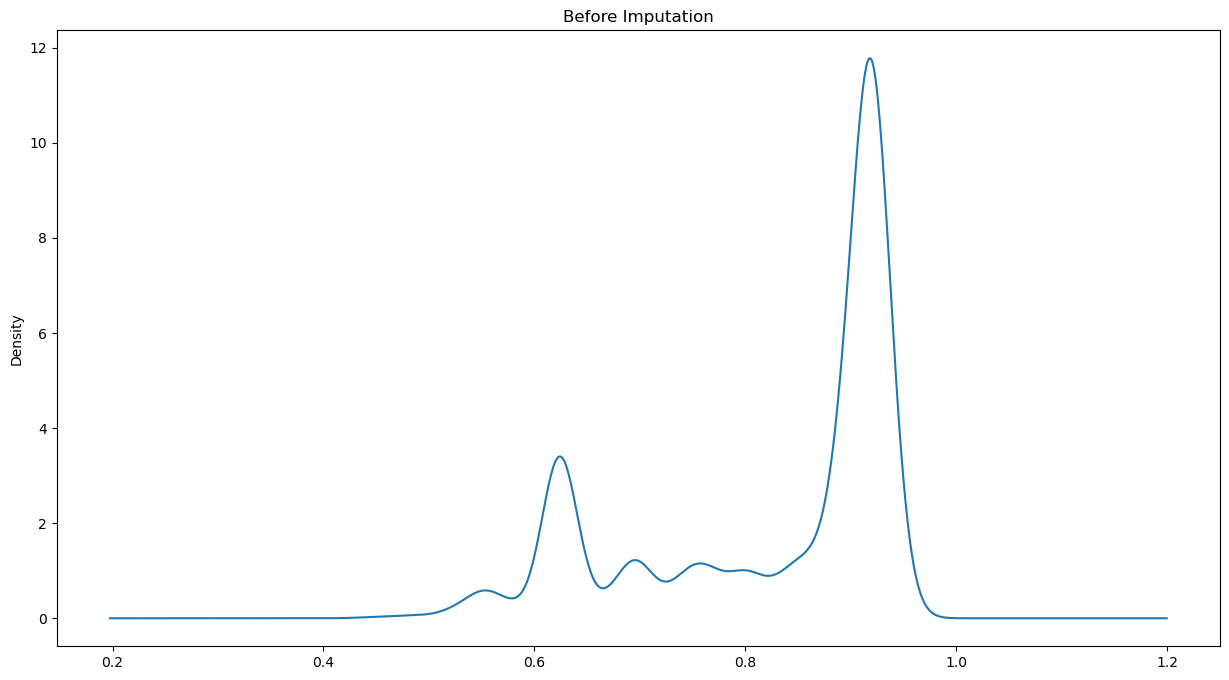

In [21]:
plt.figure(figsize=(15, 8))
plt.title('Before Imputation')
df_pre['city_development_index'].plot(kind='kde')
plt.show()

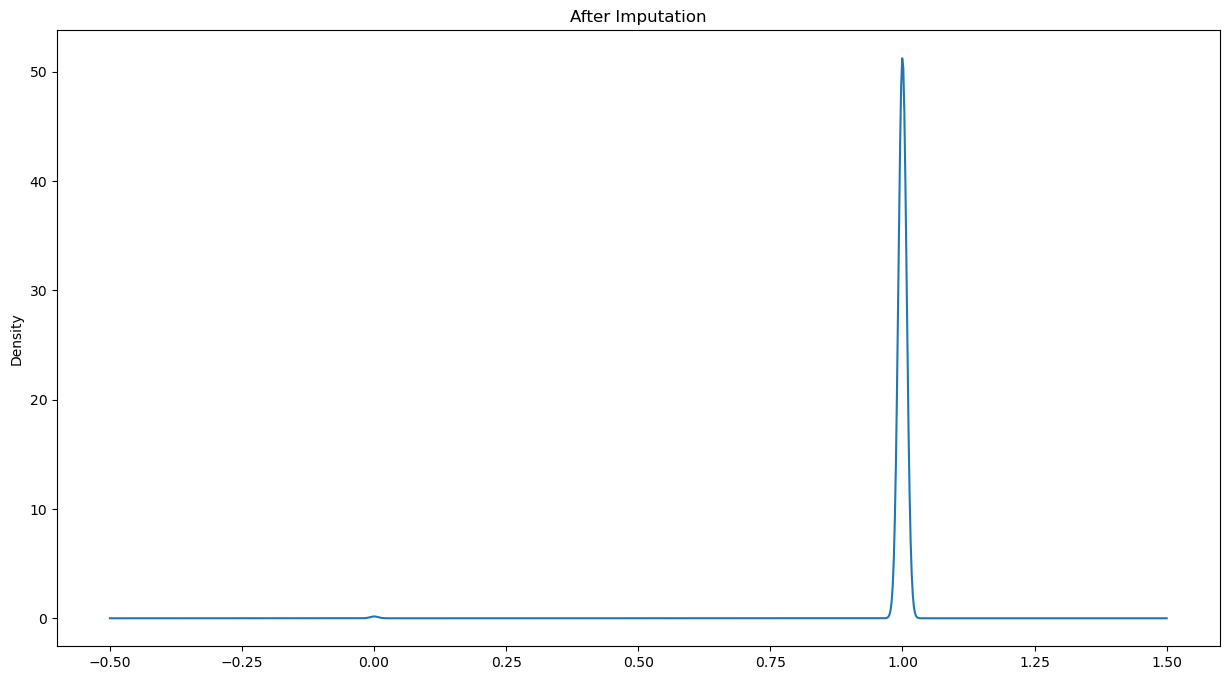

In [22]:
plt.figure(figsize=(15, 8))
plt.title('After Imputation')
df_pre1['city_development_index'].plot(kind='kde')
plt.show()

In [21]:
missing_cols = df_pre.columns[df_pre.isna().any()].tolist()
missing_cols

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [22]:
df_missing = df_pre[['enrollee_id'] + missing_cols]
df_non_missing = df_pre.drop(missing_cols, axis = 1)

In [23]:
knn_imputer = KNNImputer(n_neighbors = 3)
X = np.round(knn_imputer.fit_transform(df_missing))
df_missing = pd.DataFrame(X, columns = df_missing.columns)

In [24]:
df_pre2 = pd.merge(df_missing, df_non_missing, on='enrollee_id')

In [25]:
train = df_pre2[df_pre2['target'] != -1].reset_index(drop = True)
test = df_pre2[df_pre2['target'] == -1].reset_index(drop = True)

train['city'] = train['city'].astype('category').cat.codes
train['relevent_experience'] = train['relevent_experience'].astype('category').cat.codes

X = train.drop(['enrollee_id', 'target'], axis = 1)
Y = train['target']

test = test.drop('target', axis = 1) #합치기 위해 만들어 놨던 test data의 target 삭제

### 2. Modeling

### ▶ target 분포 확인

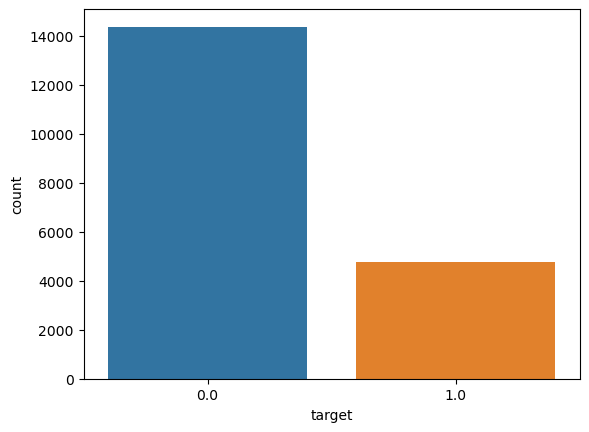

In [26]:
sns.countplot(x='target', data=train)
plt.show()

##### 불균형 데이터임을 확인할 수 있음

#### ▶ 트리 기반 모델의 특징
##### *트리 기반 모델은 스케일링이 중요하지 않으므로 스케일링은 생략
##### *트리 기반 모델: Decision trees, Random forest, Or any kind of boosted trees model
##### 여기서는 XGBoost(Extreme Gradient Boosting) 모델 사용

In [27]:
#우선 불균형 처리 없이 기본 모델로
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2 ,random_state = 42)

clf = XGBClassifier()

clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos) 
#fpr: False Positive Rate, tpr: True Positive Rate

Train AUC Score 0.9215138325567598
Test AUC Score 0.7594477634803922


##### train 성능은 좋지만 test 성능이 좋지 않아 overfitting 상태임을 알 수 있음.

In [28]:
#auc curve
def plot_auc_curve(fpr, tpr, auc): #auc는 곡선 아래 면적
    plt.figure(figsize = (16,6))
    plt.plot(fpr, tpr, 'b+', linestyle = '-') #blue로 데이터 포인트 표시, line은 실선으로
    plt.fill_between(fpr, tpr, alpha = 0.5) #투명도 0.5
    plt.ylabel('True Positive Rate')
    plt.xlabel('Fasle Positive Rate')
    plt.title(f'ROC Curve Having AUC = {auc}')

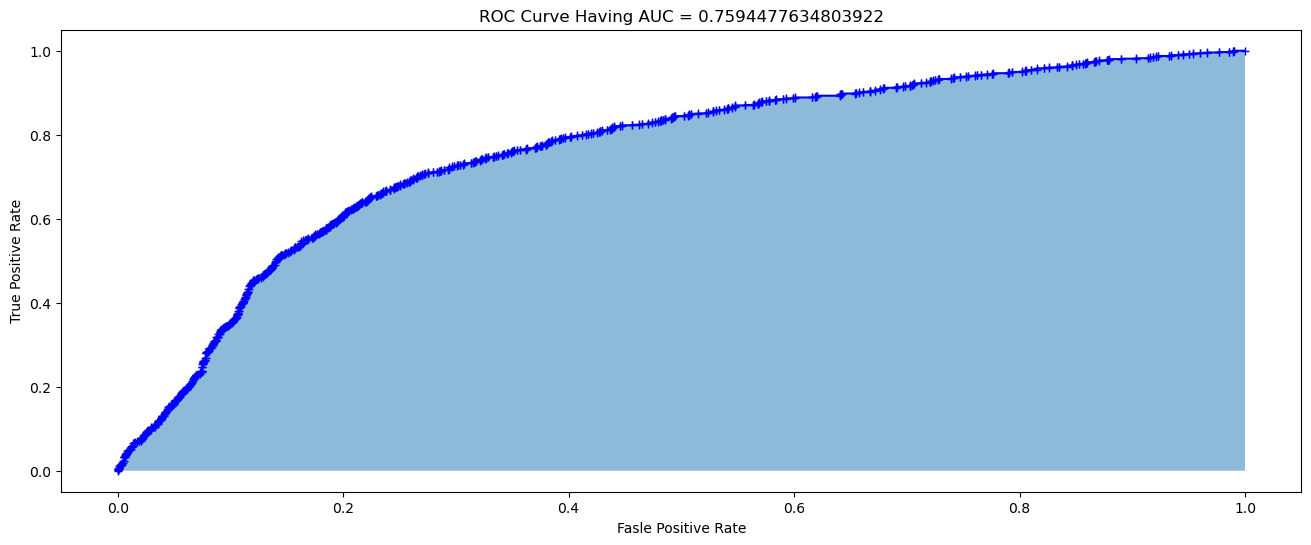

In [31]:
plot_auc_curve(fpr, tpr, auc_test)

In [32]:
#learning curves
def plot_learning_curve(model, X, Y):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=11)
    train_loss, test_loss = [], []
    
    for m in range(200, len(x_train), 200):
        model.fit(x_train.iloc[:m, :], y_train[:m])
        y_train_prob_pred = model.predict_proba(x_train.iloc[:m, :])
        train_loss.append(log_loss(y_train[:m], y_train_prob_pred))
        
        y_test_prob_pred = model.predict_proba(x_test)
        test_loss.append(log_loss(y_test, y_test_prob_pred))
        
    # 학습 곡선 플롯
    plt.figure(figsize=(15, 8))
    plt.plot(train_loss, 'r-+', label='Training Loss')
    plt.plot(test_loss, 'b-', label='Test Loss')
    plt.xlabel('Number Of Batches')
    plt.ylabel('Log-Loss')
    plt.legend(loc='best')
    plt.show()
    plt.close()  # 플롯을 초기화하여 다음 실행 시 누적되지 않도록 함

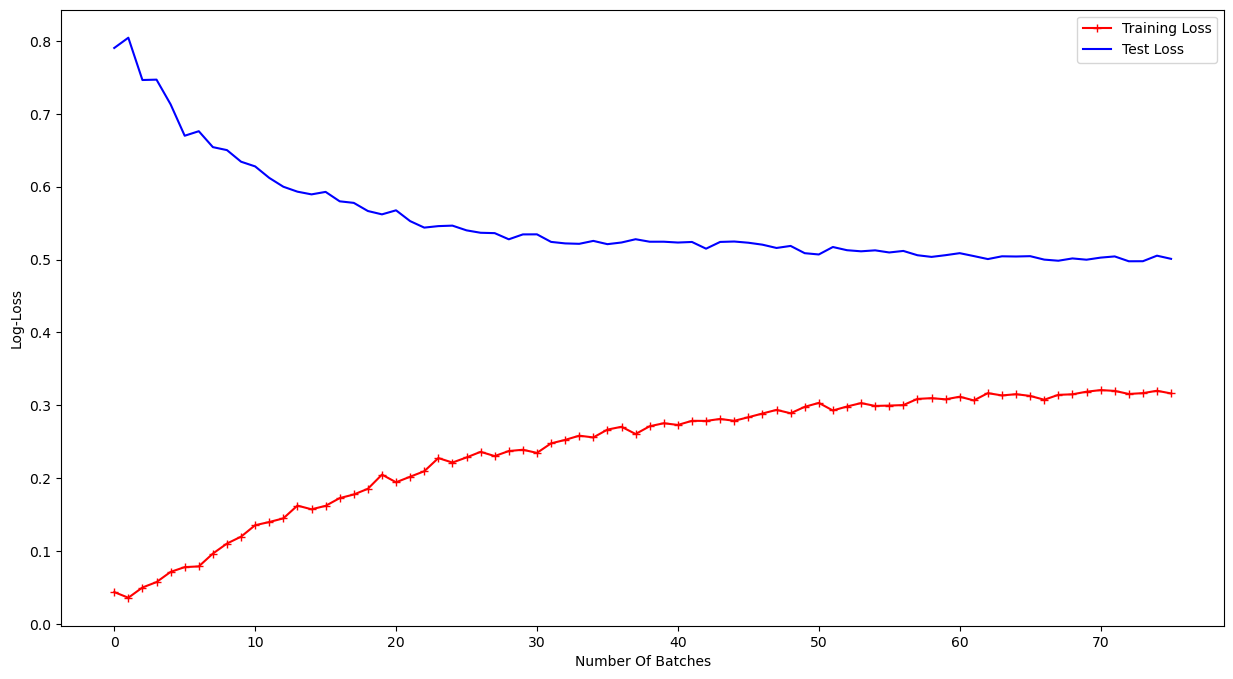

In [33]:
plot_learning_curve(XGBClassifier(), X, Y)

##### high variance problem

#### ▶ SMOTE(불균형 데이터 처리)

In [29]:
from imblearn.over_sampling import SMOTE

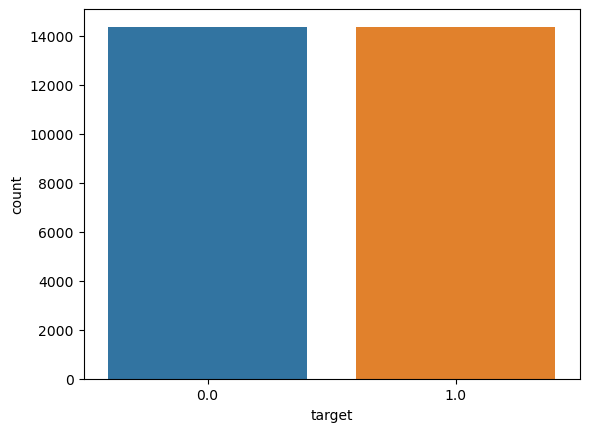

In [30]:
smote = SMOTE(random_state = 402)
X_smote, Y_smote = smote.fit_resample(X,Y)

Y_smote_df = pd.DataFrame(Y_smote, columns=['target'])
sns.countplot(x='target', data=Y_smote_df)
plt.show()

In [31]:
print(X_smote.shape)

(28762, 12)


In [32]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, Y_smote, test_size = 0.2, random_state = 42)
clf = XGBClassifier()
clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:, 1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:, 1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

Train AUC Score 0.969098336032166
Test AUC Score 0.9208333272904909


##### overfitting이 훨씬 해소되었음.

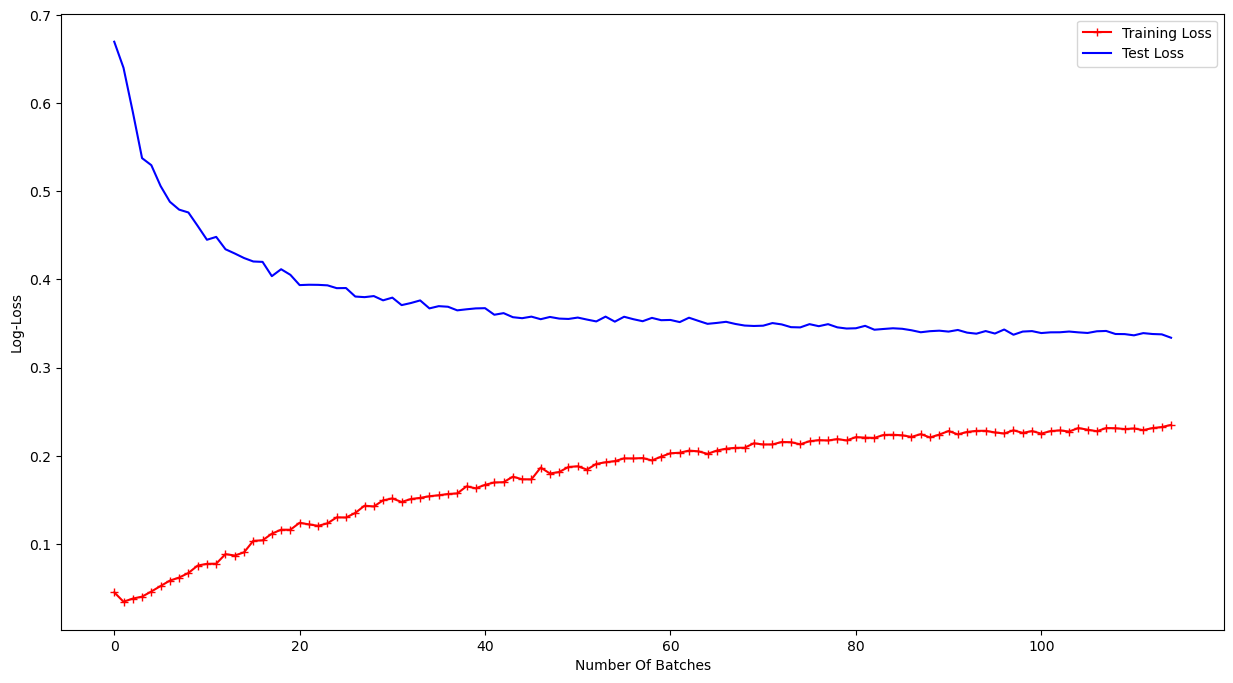

In [38]:
plot_learning_curve(XGBClassifier(), X_smote, Y_smote)

##### SMOTE를 두번 적용해서 더 많은 데이터를 생성

In [39]:
smote = SMOTE(random_state = 446)
X_smote1, Y_smote1 = smote.fit_resample(X,Y)

X_final = pd.concat([X_smote, X_smote1], axis = 0).reset_index(drop = True)
Y_final = pd.concat([Y_smote, Y_smote1], axis = 0).reset_index(drop = True)

In [40]:
print(X_final.shape)

(57524, 12)


In [41]:
X_train, X_val, y_train, y_val = train_test_split(X_final, Y_final, test_size = 0.2, random_state = 42)
clf = XGBClassifier()

clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

Train AUC Score 0.967706246269977
Test AUC Score 0.9499599380573527


##### SMOTE 1번 한 것보다 더 좋은 성능을 보임.

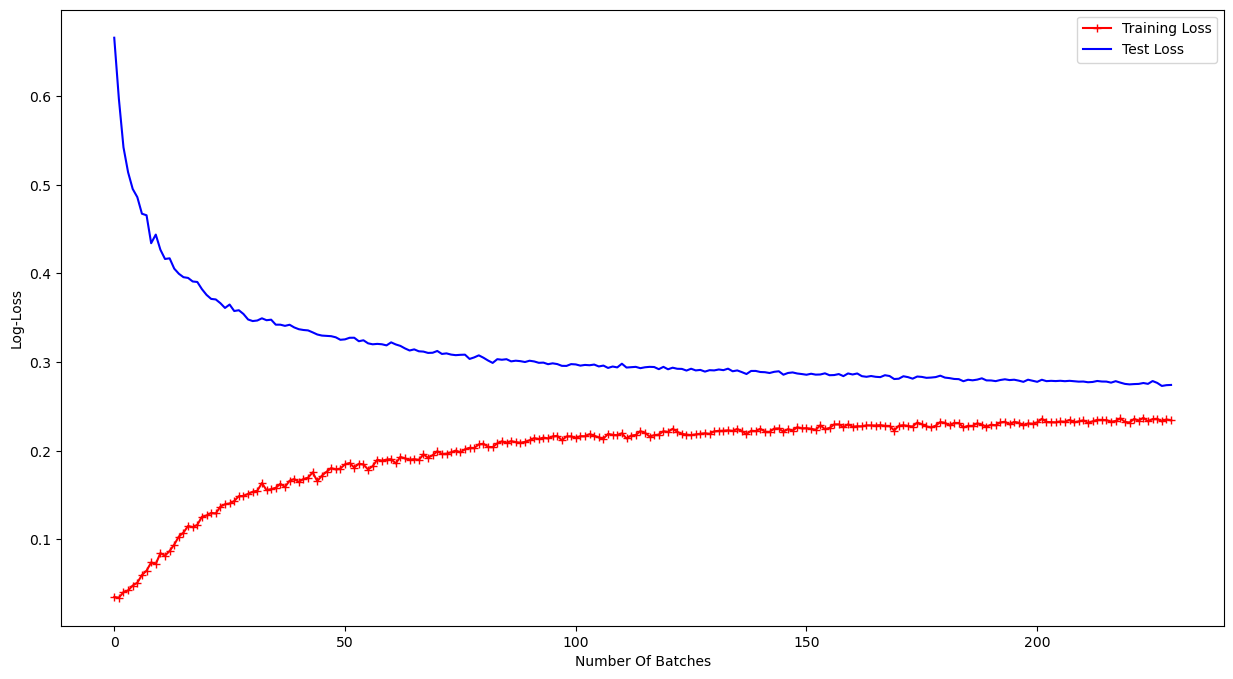

In [42]:
plot_learning_curve(XGBClassifier(), X_final, Y_final)

##### 그러나 SMOTE를 두 번 사용하는 것은 데이터의 분포를 지나치게 변경할 수 있기 때문에 사용하지는 않을 것임.

### 3. Hyperparameter Tunning

#### ▶ 하이퍼파라미터 튜닝 방법
##### 1) 그리드 서치(Grid Seach)
##### - 모든 경우의 수를 넣어서 최적의 조합을 찾는 방법
##### - Global Optimum을 찾을 가능성이 높지만 그만큼 오래 걸림.
##### 2) 랜덤 서치(Random Search)
##### - 임의로 하이퍼파라미터 조합을 샘플링함.
##### - 하이퍼파라미터 공간의 일부분만 탐색하므로, 그리드 서치보다 빠름.
##### - 전체 조합을 알아보는 게 아니므로 최적값을 놓칠 가능성이 있음.
##### 3) 베이지안 최적화(Bayesian Optimization)
##### - posterior를 사용해서 모델링
##### - 보통은 *가우시안 프로세스를 사용해서 모델링함
##### - 적은 평가 횟수로도 좋은 결과를 얻을 수 있고, 전체 공간을 효율적으로 탐색함.
##### - 구현이 복잡하고 초기 설정 및 조정이 필요함.

#### ▶ 베이지안 최적화 프로세스
##### 1) 초기화
##### - 하이퍼파라미터 공간에서 초기 샘플 선택 및 평가(모델의 성능지표)
##### - 초기 샘플의 평가 결과를 바탕으로 prior를 설정
##### 2) posterior 계산
##### - posterior은 가우시안 프로세스를 사용해서 모델링
##### - 가우시안 프로세스는 데이터 포인트들 간의 상관관계 고려해서 함수값 예측 및 불확실성 추정
##### 3) 획득 함수 최적화
##### - 흔히 사용되는 획득 함수로는 기대 개선(Expected Improvement, EI), 확률적 개선 가능성(Probability of Improvement, PI), 상한 신뢰 구간(Upper Confidence Bound, UCB) 등
##### 4) 선택된 새로운 하이퍼파라미터 조합에서 평가
##### - 평가 결과를 데이터에 추가하고, 사후 분포를 업데이트
##### 5) 반복
##### - 반복해서 최적의 조합을 찾음.
